# Проект 5. Компьютер говорит «Нет»

## Описание проекта

Наша задача написать скоринговую модель предсказания дефолта клиентов банка.

Проект выполнил Бердюгин Евгений, DSPR-40

## Описания полей

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

## Загрузка библиотек и данных

In [69]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Загрузим наши датасеты

In [70]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

Зафиксируем Random seed и версию пакетов, для воспроизводимости пакетов

In [71]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

Объединяем датасеты

In [72]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['default'] = 0 # в тесте у нас нет значения Default, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#сохраним id клиентов, для отправки результатов на Kaggle 
client_id = pd.DataFrame(data['client_id'])
data = data.drop('client_id', axis=1)

#сделаем файл для сравнивания метрик моделей
data_report = pd.DataFrame(data=None)

## Функции

In [73]:
#Функция создает отчет по метрикам модели
def get_scores(report_df, model, X_test, y_test, name):
    '''Create and add metrics into a pandas DF after experiment'''

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    report['PR-AUC'] = precision_score(y_test,model.predict(X_test))
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_Neg'] = precision_score(
        y_test, model.predict(X_test), pos_label=0)
    report['precision_Pos'] = precision_score(
        y_test, model.predict(X_test), pos_label=1)
    report['recall_Neg'] = recall_score(
        y_test, model.predict(X_test), pos_label=0)
    report['recall_Pos'] = recall_score(
        y_test, model.predict(X_test), pos_label=1)
    report['log_loss'] = log_loss(y_test, model.predict_proba(X_test))

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [74]:
#Функция определения выбросов
def detect_outliers(data):
    '''Function is called to detect outliers'''
    q1, q3 = np.percentile(sorted(data), [25, 75])

    IQR = q3 - q1

    l_b = q1 - (1.5 * IQR) # lower bound
    u_b = q3 + (1.5 * IQR) # upper bound
    outl_count = len(data[data < l_b]) + len(data[data > u_b])

    print(
        f'Lower Bound: {round(l_b,3)}, Upper Bound {round(u_b,3)}, Outliers Count: {outl_count}')

In [75]:
#функция кросс-валидации, 
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

In [76]:
#функция создания признаков из даты
def data_features(data, col):
    data['year'] = data[col].apply(lambda x: x.year)
    data['month'] = data[col].apply(lambda x: x.month)
    data['day_of_yar'] = data[col].apply(lambda x: x.timetuple()[7])
    data['weekday'] = data[col].apply(lambda x: x.weekday())
    data['is_weekend'] = data['weekday'].apply(lambda x: 1 if x in (5, 6) else 0)

## EDA

Разведывательный анализ сделан с помощью библиотеки pandasprofiling.
Ссылка на ноутбук [Pandas.profiling_for_Project_5.ipynb](https://github.com/EvgeniyBerdyugin/SkillFactory-dspr-40/blob/main/module_5/Pandas.profiling_for_Project_5.ipynb)

In [77]:
#разделим признаки на категории
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating','home_address', 'work_address',
            'sna','first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']
date_cols = ['app_date']

Посмотрим выбросы

In [78]:
for col in num_cols:
    print(col)
    detect_outliers(data[col])

age
Lower Bound: 3.0, Upper Bound 75.0, Outliers Count: 0
decline_app_cnt
Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 18677
income
Lower Bound: -22000.0, Upper Bound 90000.0, Outliers Count: 7000
bki_request_cnt
Lower Bound: -4.5, Upper Bound 7.5, Outliers Count: 2636
score_bki
Lower Bound: -3.299, Upper Bound -0.529, Outliers Count: 518


### Выводы из разведывательного анализа и анализа выбросов:

* app_date преобразовать в datetime
* education заполнить пропуски, преобразовать с помощью LabelEncoding
* sex преобразовать с помощью LabelEncoding
* age смещенное распределение, перевести в категории или логарифмировать
* car и car_type высокая корреляция с car_type, преобразовать с помощью  LabelEncoding, объеденить с car_type
* decline_app_cnt много нулевых значений, много выбросов, перевести в категории или логарифмировать
* good_work все ок
* score_bki есть выбросы, перевести в категорию
* bki_request_cnt много нулевых значений, есть выбросы, перевести в категории или логарифмировать
* region_rating слегка смещенное распределение, преобразовать в более читаемый для модели вид
* home_address и work_address высокая корреляция с work_address, объеденить с work_address
* income смещенное распределение, есть выбросы, перевести в категории или логарифмировать
* sna и first_time высокая корреляция с first_time, объеденить с first_time
* foreign_passport преобразовать с помощью LabelEncoding
* default целевая переменная. Не сбалансированная выборка. Количество одного класса сильно больше количества второго класса.Пробовать веса классов или добавать в выборку больше значений класса меньшинства.

Обработаем даты

In [79]:
for col in date_cols:
    data[col] = pd.to_datetime(data[col])

Заполним пропуски модой

In [80]:
mod_edu = data['education'].mode()
data['education'] = data['education'].fillna(mod_edu[0])

In [81]:
# imp = SimpleImputer(strategy='most_frequent')
# imp.fit(data)

# data = imp.transform(data)

# data = pd.DataFrame(data)

### Обучим наивную модель для сравнения - LogisticRegression на стандартных настойках

In [ ]:
data_naive = data[['age',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'sample', 'default']]

In [15]:
# Теперь выделим тестовую часть
train_data = data_naive.query('sample == 1').drop(['sample'], axis=1)
test_data = data_naive.query('sample == 0').drop(['sample'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

confusion_matrix
[[12933     0]
 [ 1827     0]]
f1_score
0.0
accuracy_score
0.876219512195122
recall_score
0.0
precision_score
0.0


C:\Users\negat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


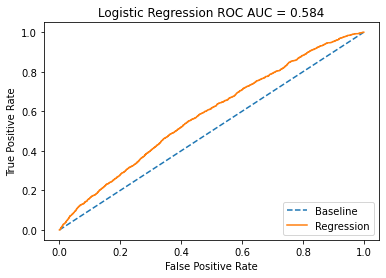

log_loss 0.3695188082814619


C:\Users\negat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\negat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos,log_loss
LogisticRegression_naive,0.583572,0.0,0.0,0.87622,0.0,1.0,0.0,0.369519


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')
print('f1_score', f1_score(y_test, y_pred), sep='\n')
print('accuracy_score', accuracy_score(y_test, y_pred), sep='\n')
print('recall_score', recall_score(y_test, y_pred), sep='\n')
print('precision_score', precision_score(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print('log_loss', log_loss(y_test, probs))

data_report = get_scores(data_report, model, X_test, 
                       y_test, 'LogisticRegression_naive')
data_report

In [17]:
print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

confusion_matrix
[[12933     0]
 [ 1827     0]]


precision-recall curve наивной модели выглядит лучше, чем если бы мы использовали случайный выбор, однако она все примеры определила в нулевой класс. Такой результат совлем не подходит для скоринговой модели. Будем пробовать ее улучшать.

In [18]:
#средняя точность тоже очень низкая
ap = average_precision_score(y_test, y_pred)
print('Average Precision (AP) = {:.2f}'.format(ap))

Average Precision (AP) = 0.12


## Посмотрим распределение логарифмированных числовых переменных

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


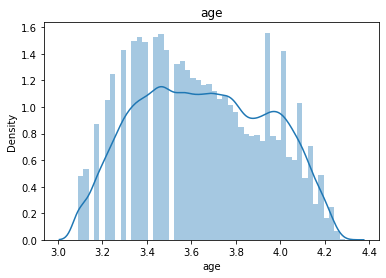

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


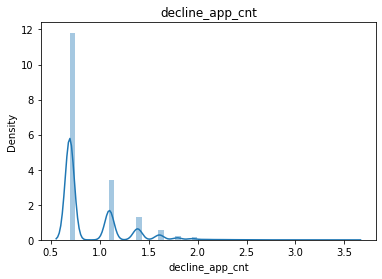

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


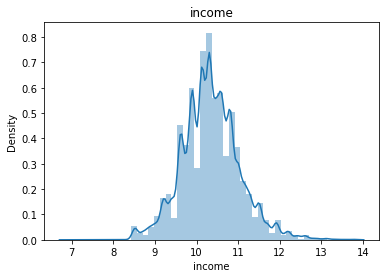

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


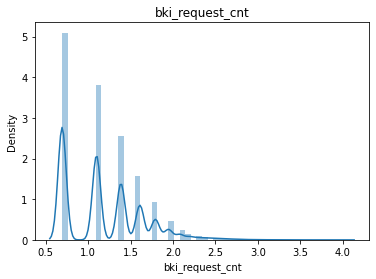

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


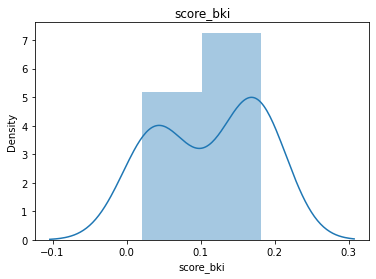

In [19]:
for col in num_cols:
    plt.figure()
    sns.distplot(np.log(data[col][data[col] > 0].dropna() +1))
    plt.title(col)
    plt.show()

income и age приобрели распределение похожее на нормальное, добавим признаки с их логарифмированными значениями

In [20]:
col_for_log = ['income', 'age']
for col in col_for_log:
    data[col+'_log'] =np.log(data[col])
    num_cols.append(col+'_log')

Сделаем категориальный признак из age

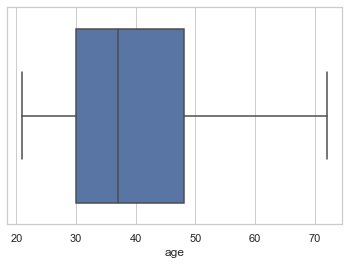

In [21]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data['age'])
plt.show()

In [22]:
q1, q3 = np.percentile(sorted(data['age']), [25, 75])
data['age_cat'] = data['age'].apply(
    lambda x: 0 if x < q1 else (2 if x > q3 else 1))

посмотрим boxplot числовых признаков

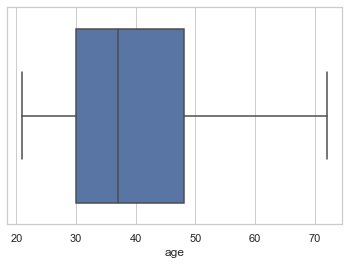

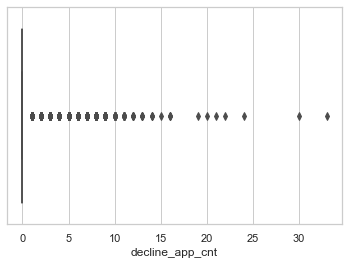

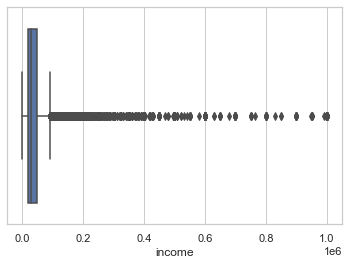

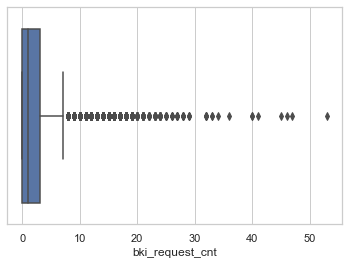

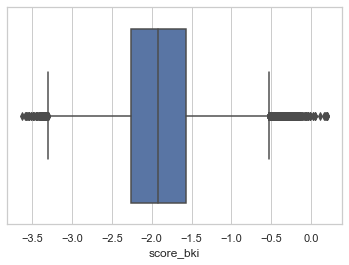

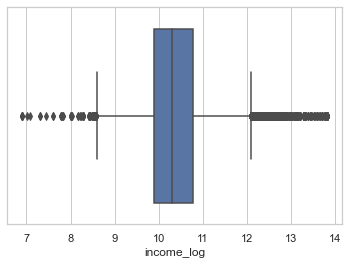

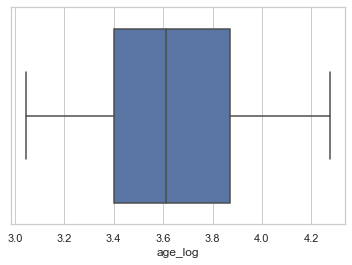

In [23]:
for i in num_cols:
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=data[i])
    plt.show()

decline_app_cnt имеет большинство нулей разделим ее на две категории: были отказы и не было

In [24]:
data['decline_app'] = data['decline_app_cnt'].apply(lambda x: 0 if x == 0 else 1)

income имеет сильное смещение и большое количество выбросов. Разделим ее на три категории low, mid и hi (0, 1, 2)

In [25]:
q1, q3 = np.percentile(sorted(data['income']), [25, 75])
data['income_cat'] = data['income'].apply(
    lambda x: 0 if x < q1 else (2 if x > q3 else 1))

bki_request_cnt имеет большинство значений около 1. Разделим ее на две категории меньше либо равно 1 и больше единицы (0, 1)

In [26]:
data['bki_request'] = data['bki_request_cnt'].apply(lambda x: 0 if x <= 1 else 1)

## Обработаем бинарные признаки

LabelEncoder для sex, foreign_passport, car, car_type

In [27]:
label_encoder = LabelEncoder()
data['sex'] = pd.Series(label_encoder.fit_transform(data['sex']))
data['foreign_passport'] = pd.Series(label_encoder.fit_transform(data['foreign_passport']))
data['car'] = pd.Series(label_encoder.fit_transform(data['car']))
data['car_type'] = pd.Series(label_encoder.fit_transform(data['car_type']))

объединим car  и car_type

In [28]:
data['car_car_type'] = data['car'] + data['car_type']

## Обработаем категориальные признаки

Заменим значения educatoin, значениями от 0 до 4, в зависимости от ранга
образования

In [29]:
data_edu = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 3, 'ACD': 4}
data['education'] = data['education'].apply(lambda x: data_edu[x])

Объеденим home_adress и work_adress

In [30]:
data['home_work_address'] = data['home_address'] + data['work_address']

Объединим sna и first_time

In [31]:
data['sna_first_time'] = data['sna'] + data['first_time']

## Feature engineering

### создадим признаки из даты

In [32]:
data_features(data, 'app_date')

Посмотрим за какой период данные

In [33]:
data['year'].value_counts()

2014    110148
Name: year, dtype: int64

только 2014 год. Удилим этот столбец

In [34]:
data = data.drop('year', axis=1)
data['month'].value_counts(normalize=True)*100

3    28.685950
2    24.600537
4    23.846098
1    22.867415
Name: month, dtype: float64

Данные за 4 месяца, в целом равномерно распределены

In [35]:
data['weekday'].value_counts(normalize=True)*100

1    16.505066
0    16.212732
2    15.961252
3    15.815993
4    15.205905
5    11.077823
6     9.221230
Name: weekday, dtype: float64

Данные за все дни периода

In [36]:
data = data.drop('app_date', axis=1)

### Приведем region_rating к значениям от 0 до 6

In [37]:
data_region = {20: 0, 30: 1, 40: 2, 50: 3, 60: 4, 70: 5, 80: 6}
data['region_rating'] = data['region_rating'].apply(lambda x: data_region[x])

## Проверим корреляции новых признаков

Распределим новые признаки по типам

In [38]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'decline_app', 'bki_request', 'is_weekend']
cat_cols = ['education', 'region_rating','home_address', 'work_address', 'sna','first_time', 'income_cat', 'car_car_type', 'home_work_address', 'sna_first_time', 'month', 'weekday', 'age_cat']
num_cols = ['age', 'age_log', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'income_log', 'day_of_yar']

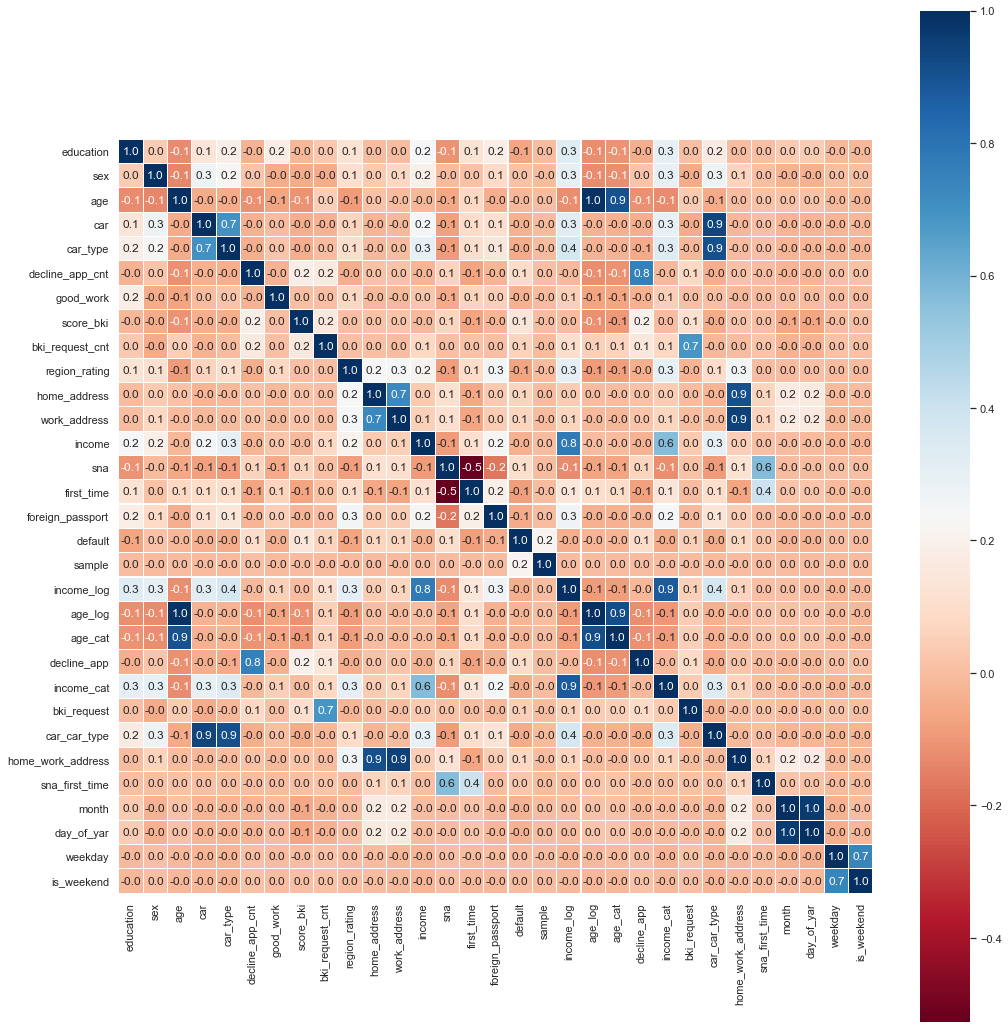

In [39]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(data.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

Корреляции предсказуемо имеются у новых признаков, с признаками на основе которых они были созданы. Однако путем экспериментов, удаление признаков ведет к ухудшению показателей подели.

Удаление сильно коррелирующих переменных привело к ухудшению модели.

### Посмотрим корреляцию признаков с целевой переменной

In [ ]:
abs(data.drop(['sample'], axis=1).corr()['default']).sort_values()

In [ ]:
Корреляция целевой переменной только с числовой переменной

In [ ]:
abs(data[num_cols + ['default']].corr()['default']).sort_values()

### Посмотрим значимость непрерывных переменных, с помощью f classif функции

In [ ]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Удаление малозначительных переменных так же приводит к ухудшению модели.

Смотрим значимость категориальных признаков с помощью функции mutual info classif

In [ ]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Удаление малозначительных категориальных признаков приводит к ухудшению показателей модели.

Путем экспериментов выяснено, что модель работает лучше, если категориальные признаки закодировать с помощью One-Hot Encoding 

In [ ]:
data = pd.get_dummies(data, columns=cat_cols)

Добавим полиноминальные признаки, после экспериментов - модель переобучается. На тестовых данных дает 100% результат, однако на Каггле получается низкий результат

In [ ]:
# poly = PolynomialFeatures(2)
# data_pol = poly.fit_transform(data[num_cols])
# data_pol = pd.DataFrame(data_pol)
# data1 = data.join(data_pol)

Выберем дискретные и числовые признаки, вместе с полиноминальными переменными, отсеем их по F-class и Mutual-info-class - так же приводит к переобучению и плхим результатам в полевых условиях.

In [ ]:
# data_num = data1[num_cols + list(data_pol.columns)]
# data_dis = data1.drop(num_cols + list(data_pol.columns), axis=1)
# info_data = data1[['default', 'sample']]
# y = data.default

In [ ]:
# X_dis = SelectPercentile(chi2, percentile=10).fit_transform(data_dis, y)
# X_num = SelectPercentile(f_classif, percentile=10).fit_transform(data_num, y)
# data4 = pd.DataFrame(np.hstack([X_num, X_dis]))

In [ ]:
# data4 = data4.join(info_data)

# Модели

## Использовал только LogisticRegression

### В итоге лучший результат показывает LogisticRegression на всех признаках, на стандартных настройках

Пробовал на стандартизацию отправлять только числовые переменные, результат не меняется.

In [ ]:
#колонки на отдельное стандартизирование(не очень сработало)
#scale_col = ['age', 'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'income_log', 'age_log', 'car_car_type', 'home_work_address', 'sna_first_time', 'day_of_yar']

In [ ]:
# # Теперь выделим тестовую часть с предварительной стандартизацией
# #data_scal = pd.DataFrame(StandardScaler().fit_transform(data[scale_col].values))
# #data_disc = data.drop(scale_col, axis=1)
# #data2 = data_disc.join(data_scal)
# train_data = data.query('sample == 1').drop(['sample'], axis=1)
# test_data = data.query('sample == 0').drop(['sample'], axis=1)

# y = train_data.default.values            # наш таргет
# X = train_data.drop(['default', 'client_id'], axis=1)

Пробовал undersampling, результат хуже

In [41]:
# Теперь выделим тестовую часть
data = data.join(client_id)
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

# #undersampling работает хуже
# under_train = pd.concat([train_data[train_data['default']==0].sample(
#     len(train_data[train_data['default']==1]), 
#     random_state=RANDOM_SEED), train_data[train_data['default']==1]])
# y = under_train.default.values            # наш таргет
# X = under_train.drop(['default', 'client_id'], axis=1)


#обычная выборка
y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

#X = MinMaxScaler(feature_range = (0, 1)).fit_transform(X.values)
X = StandardScaler().fit_transform(X.values)
#X = RobustScaler().fit_transform(X.values) сработал хуже
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Так же пробовал разные стандартизаторы, результат не менялся.

### LogisticRegression на стандартных настойках

confusion_matrix
[[12871    62]
 [ 1788    39]]
f1_score
0.04045643153526972
accuracy_score
0.8746612466124661
recall_score
0.021346469622331693
precision_score
0.38613861386138615


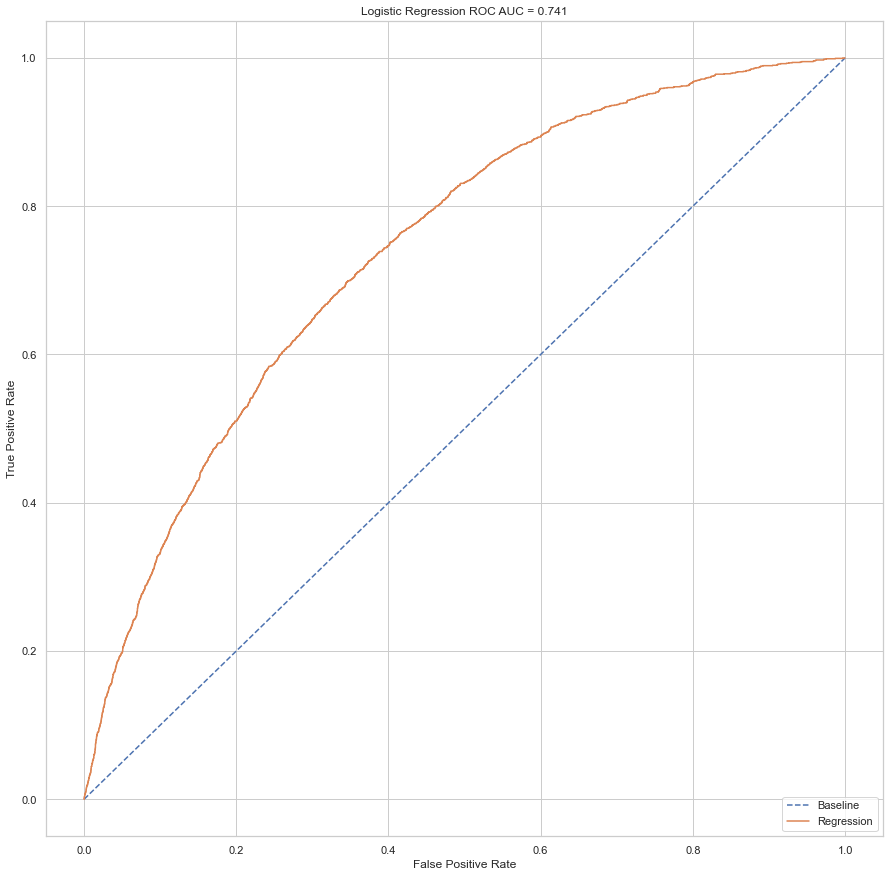

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos,log_loss
LogisticRegression_naive,0.583572,0.000000,0.000000,0.876220,0.000000,1.000000,0.000000,0.369519
LogisticRegression_standart,0.740767,0.386139,0.040456,0.878027,0.386139,0.995206,0.021346,0.334272


In [42]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')
print('f1_score', f1_score(y_test, y_pred), sep='\n')
print('accuracy_score', accuracy_score(y_test, y_pred), sep='\n')
print('recall_score', recall_score(y_test, y_pred), sep='\n')
print('precision_score', precision_score(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#print(log_loss(y_test, probs))

data_report = get_scores(data_report, model, X_test, 
                       y_test, 'LogisticRegression_standart')
data_report

Посмотрим, не переобучется ли у нас модель

[train] F1-score = 0.73 +/- 0.00
[valid] F1-score = 0.73 +/- 0.01


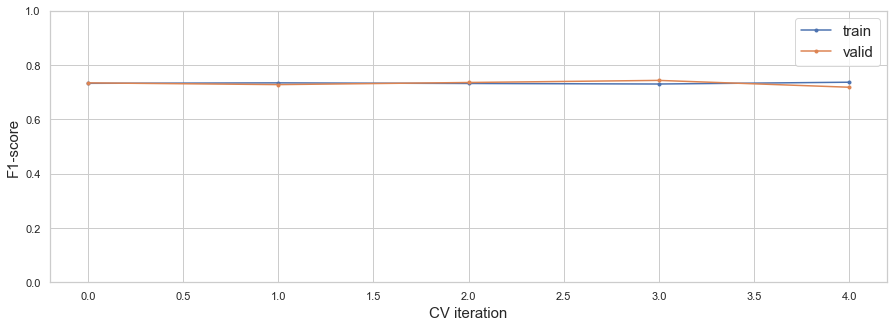

In [43]:
cv_metrics = cross_validate(model, X, y, cv=5, scoring='roc_auc', return_train_score=True)
plot_cv_metrics(cv_metrics)

Судя результатам - нет

Модель показала мой лучший результат на Каггле - 0.73989. Однако по другим метрикам мы видим сущетственный недостаток модели. по confusion matrix мы видим, что модель достаточно уверенно угадывает клиентов, которые вернут кредит, и только 2% дефолтных клиентов. Думаю, что на Каггле она угадывает несколько больше, но в любом случае, такая модель может принести большие убытки банку. Это мы так же видим по низкому показателю recall и f1-score. Причина может быть в несбалансированности выборки. Мы ее заметили еще на стадии EDA. Попробуем доработать модель.

### LogisticRegression и GridSearchCV. Попробуем подобрать лучшие гиперпараметры

In [65]:
model = LogisticRegression(max_iter=500)
class_weight = [None, 'balanced']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10]
penalty = ['l1', 'l2', None]
solver = ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg']
# Создадим гиперпараметры
hyperparameters = dict(penalty=penalty, C=C, solver=solver, class_weight=class_weight)
Grid = GridSearchCV(model, hyperparameters, cv=4, verbose=0, scoring='roc_auc', n_jobs=4)
Grid.fit(X_train, y_train)
Grid.best_params_

C:\Users\negat\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.5               nan 0.5               nan 0.7213306
 0.72395584 0.72133016 0.72133034 0.72133048        nan        nan
        nan        nan        nan        nan 0.5               nan
 0.5               nan 0.72545883 0.72545394 0.72545901 0.72545889
 0.72545863        nan        nan        nan        nan        nan
        nan 0.70059176        nan 0.70058124        nan 0.72866733
 0.72883505 0.72866839 0.7286644  0.72866922        nan        nan
        nan        nan        nan        nan 0.7206822         nan
 0.72112701        nan 0.72913966 0.72914974 0.72913985 0.72914022
 0.72913963        nan        nan        nan        nan        nan
        nan 0.72874464        nan 0.7287351         nan 0.72905245
 0.72909681 0.72905282 0.72905269 0.72905318        nan        nan
        nan        nan        nan        nan 0.7290325

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Пробовал различные метрики истользовать для выбора лучших параметров в GridSearchCV, roc_auc показал себя лучше

Как и планировалось выше, посковик выбрал параметр, учитывающий несбалансированность выборки - class_weight. Обучим модель на новых параметрах.

In [66]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

X = StandardScaler().fit_transform(X.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

confusion_matrix
[[8672 4261]
 [ 576 1251]]
f1_score
0.3409183812508516
accuracy_score
0.672289972899729
recall_score
0.6847290640394089
precision_score
0.22695936139332365


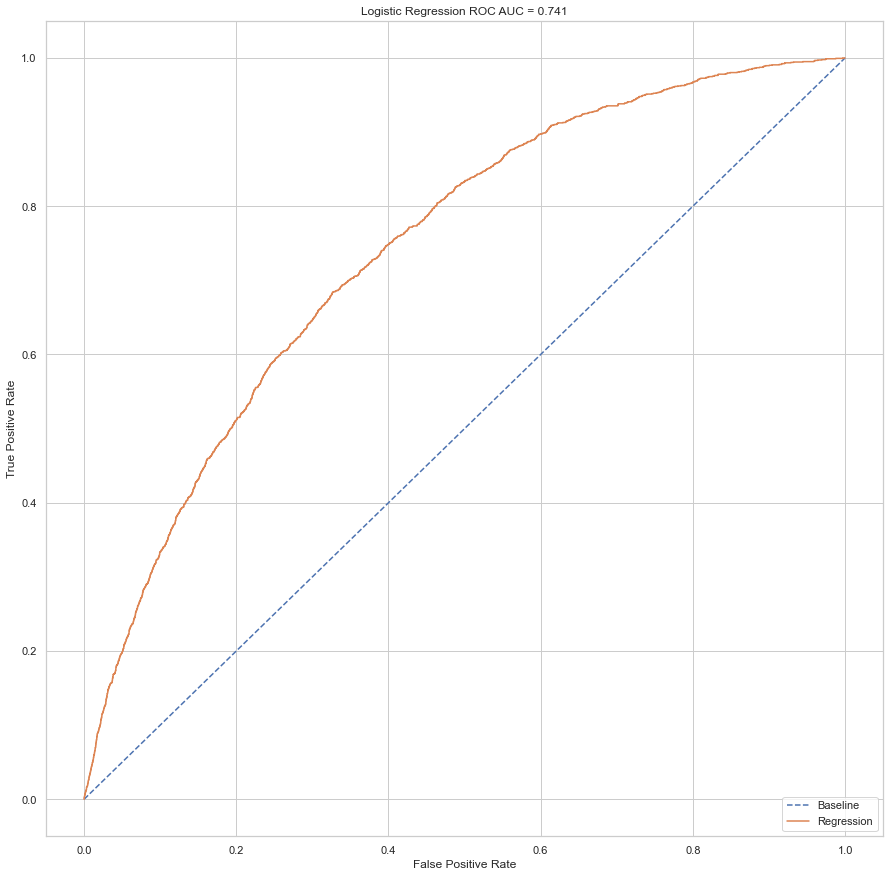

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos,log_loss
LogisticRegression_naive,0.583572,0.000000,0.000000,0.876220,0.000000,1.000000,0.000000,0.369519
LogisticRegression_standart,0.740767,0.386139,0.040456,0.878027,0.386139,0.995206,0.021346,0.334272
LogisticRegression_GridCV,0.740553,0.226959,0.340918,0.937716,0.226959,0.670533,0.684729,0.606227
LogisticRegression_GridCV,0.740552,0.226959,0.340918,0.937716,0.226959,0.670533,0.684729,0.606160
LogisticRegression_GridCV,0.740552,0.227570,0.341743,0.937973,0.227570,0.671151,0.685824,0.606317
LogisticRegression_GridCV,0.740180,0.225289,0.338896,0.937283,0.225289,0.667904,0.683634,0.609044
LogisticRegression_GridCV,0.740553,0.226959,0.340918,0.937716,0.226959,0.670533,0.684729,0.606227


In [67]:
model = LogisticRegression(penalty='l2',
                           C=0.1,
                           class_weight='balanced',
                           solver='liblinear'
                           )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')
print('f1_score', f1_score(y_test, y_pred), sep='\n')
print('accuracy_score', accuracy_score(y_test, y_pred), sep='\n')
print('recall_score', recall_score(y_test, y_pred), sep='\n')
print('precision_score', precision_score(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#print(log_loss(y_test, probs))

data_report = get_scores(data_report, model, X_test, 
                       y_test, 'LogisticRegression_GridCV')
data_report

Посмотрим, не переобучется ли у нас модель

[train] F1-score = 0.73 +/- 0.00
[valid] F1-score = 0.73 +/- 0.01


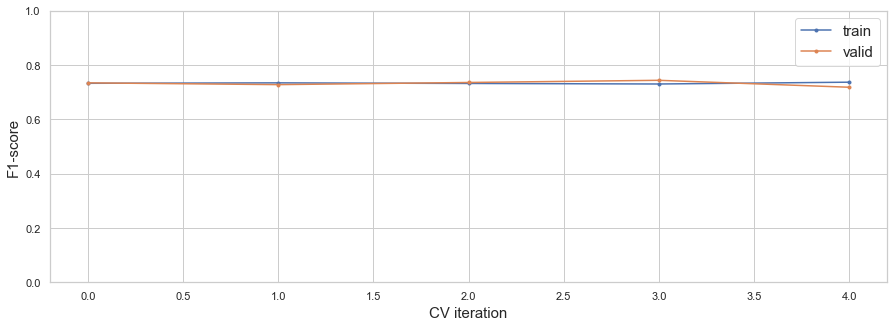

In [49]:
cv_metrics = cross_validate(model, X, y, cv=5, scoring='roc_auc', return_train_score=True)
plot_cv_metrics(cv_metrics)

Судя результатам - нет

Не смотря на то, что модель показала на Каггле результаты хуже -  0.73472, я считаю эта модель лучше справляется с задачей скоринга. Она угадывает по нашим метрикам до 69% дефолтных клиентов, хотя и теряет до 33% лояльных клиентов. Модель все еще требует доработки, возможно стояло бы попробовать более продвинутые классификаторы.

### Отправим результаты на Каггл

In [68]:
test_data = test_data.drop(['default'], axis=1)
test_client_id = pd.DataFrame()
test_client_id['client_id'] = test_data['client_id']
test_data = test_data.drop(['client_id'], axis=1)
test_data = StandardScaler().fit_transform(test_data.values)
predict_submission = model.predict_proba(test_data)
test_client_id['default'] = predict_submission[:,1]
test_client_id.to_csv('submission.csv', index=False)
test_client_id.head(10)

,client_id,default
0,74835,0.210571
1,17527,0.778717
2,75683,0.280099
3,26883,0.406729
4,28862,0.161504
5,99881,0.734890
6,26630,0.757571
7,79934,0.213000
8,16605,0.143718
9,105449,0.149794
